# Project 2 - Notebook

Please make sure your solution is divided into multiple code cells, explained clearly and properly, and most importantly, pretty.


In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
import os,time
from pyspark.sql import SparkSession
 
spark = SparkSession.builder.appName("my_project_2").getOrCreate()

## Read Sub Demographic data

In [0]:
demographic_df = spark.read.parquet("dbfs:/FileStore/project_b_data/proj_B_demographic/")
demographic_df.printSchema()
display(demographic_df.limit(10))

root
 |-- household_id: long (nullable = true)
 |-- household_size: integer (nullable = true)
 |-- num_adults: integer (nullable = true)
 |-- num_generations: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- race_code: string (nullable = true)
 |-- dwelling_type: string (nullable = true)
 |-- home_owner_status: string (nullable = true)
 |-- length_residence: integer (nullable = true)
 |-- home_market_value: double (nullable = true)
 |-- net_worth: double (nullable = true)
 |-- gender_individual: string (nullable = true)
 |-- education_highest: string (nullable = true)



household_id,household_size,num_adults,num_generations,marital_status,race_code,dwelling_type,home_owner_status,length_residence,home_market_value,net_worth,gender_individual,education_highest
85,2,1,2,B,W,S,O,15,0.125,0.05,F,1
2073,1,1,2,M,H,S,O,15,0.15,0.1,F,1
2523,7,6,3,M,W,S,O,15,0.1,0.1,M,2
2717,3,2,2,S,W,S,O,11,0.125,0.2,M,3
3364,2,2,2,M,W,S,O,15,0.1,0.1,M,1
4046,4,3,3,M,W,S,O,6,0.075,0.05,F,1
4303,1,1,1,S,W,S,O,15,0.15,0.2,M,1
4559,3,2,2,S,W,S,O,12,0.175,0.2,F,2
5277,3,2,2,M,W,S,R,15,0.125,0.02,M,2
5440,1,1,1,S,W,S,O,8,0.225,0.2,F,1


## Read Static Viewing Data

In [0]:
schema = StructType([
    StructField("device_id", StringType(), True),
    StructField("event_date", StringType(), True),
    StructField("event_time", StringType(), True),     
    StructField("station_num", IntegerType(), True),
    StructField("prog_code", StringType(), True),
    StructField("household_id", IntegerType(), True)
])

viewing_static_df = spark.read.schema(schema).option("header", True).csv("dbfs:/FileStore/project_b_data/viewing_static_csv/")

viewing_static_df.printSchema()
display(viewing_static_df.limit(10))

root
 |-- device_id: string (nullable = true)
 |-- event_date: string (nullable = true)
 |-- event_time: string (nullable = true)
 |-- station_num: integer (nullable = true)
 |-- prog_code: string (nullable = true)
 |-- household_id: integer (nullable = true)



device_id,event_date,event_time,station_num,prog_code,household_id
001bd74cc8d1,20150120,181338,75523,EP000009110053,3783713
10ea5940d694,20150120,181338,11218,MV001054110000,3787015
44e08ed80c35,20150120,181338,11713,SH004464010000,43921
0000048de4f2,20150120,181338,65626,MV000506130000,3672067
0000059867a7,20150120,181338,58812,EP019199930005,3645541
000011ff9ba9,20150120,181338,18510,EP010855880111,3642303
00000254e5f6,20150120,181338,35513,EP000369550087,3825751
000002bd8a47,20150120,181338,10035,EP013413450102,2971023
000003c4c597,20150120,181338,59337,MV000744670000,2358722
00407bba00fe,20150120,181338,14771,EP015899250028,2838674


## Static Data Analysis (65 points)

### Feature Extraction

 **Normalization of numeric columns**

This block manually normalizes all numeric columns using min-max scaling.  
For each numeric column, the minimum and maximum values are calculated, and a new scaled version of the column is created using the formula `(x - min) / (max - min)`.  
All scaled columns are then added to the DataFrame.  

An example with `household_size` and `home_market_value` is shown to compare the original and normalized values.


In [0]:

# Define the list of numeric columns to normalize
num_cols = ['household_size', 'num_adults', 'num_generations',
            'length_residence', 'home_market_value', 'net_worth']

# Compute min and max for each numeric column and store in a dictionary
min_max_values = {}
for col_name in num_cols:
    # Calculate minimum value for the column
    min_val = demographic_df.agg(min(col(col_name))).first()[0]
    # Calculate maximum value for the column
    max_val = demographic_df.agg(max(col(col_name))).first()[0]
    # Store the min and max as a tuple in the dictionary
    min_max_values[col_name] = (min_val, max_val)

# Create a new DataFrame with normalized numeric columns
demo_normalized_df = demographic_df
for col_name in num_cols:
    min_val, max_val = min_max_values[col_name]
    scaled_col = f"{col_name}_scaled"  # Name for the new scaled column
    # Add a new column with normalized values using min-max scaling
    demo_normalized_df = demo_normalized_df.withColumn(
        scaled_col,
        (col(col_name) - min_val) / (max_val - min_val)
    )

# Prepare a list of all the new scaled column names
scaled_cols = [f"{col}_scaled" for col in num_cols]


In [0]:

print(f"household_size: min = {min_max_values['household_size'][0]}, max = {min_max_values['household_size'][1]}")
print(f"home_market_value: min = {min_max_values['home_market_value'][0]}, max = {min_max_values['home_market_value'][1]}")
display(demo_normalized_df.select("household_size", "household_size_scaled","home_market_value","home_market_value_scaled").limit(5))

household_size: min = 1, max = 9
home_market_value: min = 0.001, max = 1.0


household_size,household_size_scaled,home_market_value,home_market_value_scaled
2,0.125,0.125,0.12412412412412413
1,0.0,0.15,0.14914914914914915
7,0.75,0.1,0.0990990990990991
3,0.25,0.125,0.12412412412412413
2,0.125,0.1,0.0990990990990991


**Indexing, one-hot encoding, and feature vector assembly**

In this block, all categorical columns are processed using a StringIndexer to convert each category into a numeric index. Each index is then transformed into a binary vector using a OneHotEncoder to avoid introducing a false order in the data. 

The final feature vector combines all normalized numeric columns (`scaled_cols`) with all one-hot encoded categorical columns. A VectorAssembler is used to merge everything into a single `features` column that can be used for PCA or clustering.

The pipeline is built with the indexers, encoders, and assembler, then fitted and applied to the normalized demographic DataFrame. A `display` shows the resulting DataFrame like required and another one shows only ID and features vector for clarty.


In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# Define categorical columns
cat_cols = ['marital_status', 'race_code', 'dwelling_type',
            'home_owner_status', 'gender_individual', 'education_highest']

# Create indexers and encoders lists
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_index") for c in cat_cols]
encoders = [OneHotEncoder(inputCol=f"{c}_index", outputCol=f"{c}_ohe") for c in cat_cols]

# Combine all input columns for the final features vector
# --> normalized numeric columns + one-hot encoded categorical columns
assembler_inputs = scaled_cols + [f"{c}_ohe" for c in cat_cols]

assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

# Build the pipeline stages: indexers + encoders + assembler
transformer_pipeline = Pipeline(stages=indexers + encoders + [assembler])

# Fit and transform on your normalized DataFrame
model = transformer_pipeline.fit(demo_normalized_df)
prepared_demo_df = model.transform(demo_normalized_df)

# Display all
display(prepared_demo_df.limit(7))

household_id,household_size,num_adults,num_generations,marital_status,race_code,dwelling_type,home_owner_status,length_residence,home_market_value,net_worth,gender_individual,education_highest,household_size_scaled,num_adults_scaled,num_generations_scaled,length_residence_scaled,home_market_value_scaled,net_worth_scaled,marital_status_index,race_code_index,dwelling_type_index,home_owner_status_index,gender_individual_index,education_highest_index,marital_status_ohe,race_code_ohe,dwelling_type_ohe,home_owner_status_ohe,gender_individual_ohe,education_highest_ohe,features
85,2,1,2,B,W,S,O,15,0.125,0.05,F,1,0.125,0.0,0.5,1.0,0.12412412412412413,0.05,3.0,0.0,0.0,0.0,1.0,0.0,"Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List())","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(), values -> List())","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 18, indices -> List(0, 2, 3, 4, 5, 9, 12, 13, 15), values -> List(0.125, 0.5, 1.0, 0.12412412412412413, 0.05, 1.0, 1.0, 1.0, 1.0))"
2073,1,1,2,M,H,S,O,15,0.15,0.1,F,1,0.0,0.0,0.5,1.0,0.14914914914914915,0.1,0.0,2.0,0.0,0.0,1.0,0.0,"Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(2), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(), values -> List())","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 18, indices -> List(2, 3, 4, 5, 6, 11, 12, 13, 15), values -> List(0.5, 1.0, 0.14914914914914915, 0.1, 1.0, 1.0, 1.0, 1.0, 1.0))"
2523,7,6,3,M,W,S,O,15,0.1,0.1,M,2,0.75,1.0,1.0,1.0,0.0990990990990991,0.1,0.0,0.0,0.0,0.0,0.0,1.0,"Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))","Map(vectorType -> dense, length -> 18, values -> List(0.75, 1.0, 1.0, 1.0, 0.0990990990990991, 0.1, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0))"
2717,3,2,2,S,W,S,O,11,0.125,0.2,M,3,0.25,0.2,0.5,0.7333333333333333,0.12412412412412413,0.2,1.0,0.0,0.0,0.0,0.0,2.0,"Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(2), values -> List(1.0))","Map(vectorType -> dense, length -> 18, values -> List(0.25, 0.2, 0.5, 0.7333333333333333, 0.12412412412412413, 0.2, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0))"
3364,2,2,2,M,W,S,O,15,0.1,0.1,M,1,0.125,0.2,0.5,1.0,0.0990990990990991,0.1,0.0,0.0,0.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, le

In [0]:
# Display features column only
display(prepared_demo_df.select("household_id", "features").limit(7))

household_id,features
85,"Map(vectorType -> sparse, length -> 18, indices -> List(0, 2, 3, 4, 5, 9, 12, 13, 15), values -> List(0.125, 0.5, 1.0, 0.12412412412412413, 0.05, 1.0, 1.0, 1.0, 1.0))"
2073,"Map(vectorType -> sparse, length -> 18, indices -> List(2, 3, 4, 5, 6, 11, 12, 13, 15), values -> List(0.5, 1.0, 0.14914914914914915, 0.1, 1.0, 1.0, 1.0, 1.0, 1.0))"
2523,"Map(vectorType -> dense, length -> 18, values -> List(0.75, 1.0, 1.0, 1.0, 0.0990990990990991, 0.1, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0))"
2717,"Map(vectorType -> dense, length -> 18, values -> List(0.25, 0.2, 0.5, 0.7333333333333333, 0.12412412412412413, 0.2, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0))"
3364,"Map(vectorType -> dense, length -> 18, values -> List(0.125, 0.2, 0.5, 1.0, 0.0990990990990991, 0.1, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0))"
4046,"Map(vectorType -> dense, length -> 18, values -> List(0.375, 0.4, 1.0, 0.4, 0.07407407407407407, 0.05, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0))"
4303,"Map(vectorType -> sparse, length -> 18, indices -> List(3, 4, 5, 7, 9, 12, 13, 14, 15), values -> List(1.0, 0.14914914914914915, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))"


### Visual Analysis

**PCA projection and scatter plot**

In this part, a PCA is applied with `k=2` to project the full feature vector to two dimensions.  
The result is first displayed to check both the original `features` and the new `pca_features` columns.

The `vector_to_array` function is used to convert the Spark ML vector to an array, making it easy to extract the first and second principal components.  
These components are saved as `pca_x` and `pca_y` and plotted as a 2D scatter plot using the Pandas shortcut.  
The scatter uses pink points, as required, to visualize how the data is spread in the reduced space.


Displaying all the df


household_id,household_size,num_adults,num_generations,marital_status,race_code,dwelling_type,home_owner_status,length_residence,home_market_value,net_worth,gender_individual,education_highest,household_size_scaled,num_adults_scaled,num_generations_scaled,length_residence_scaled,home_market_value_scaled,net_worth_scaled,marital_status_index,race_code_index,dwelling_type_index,home_owner_status_index,gender_individual_index,education_highest_index,marital_status_ohe,race_code_ohe,dwelling_type_ohe,home_owner_status_ohe,gender_individual_ohe,education_highest_ohe,features,pca_features
85,2,1,2,B,W,S,O,15,0.125,0.05,F,1,0.125,0.0,0.5,1.0,0.12412412412412413,0.05,3.0,0.0,0.0,0.0,1.0,0.0,"Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List())","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(), values -> List())","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 18, indices -> List(0, 2, 3, 4, 5, 9, 12, 13, 15), values -> List(0.125, 0.5, 1.0, 0.12412412412412413, 0.05, 1.0, 1.0, 1.0, 1.0))","Map(vectorType -> dense, length -> 2, values -> List(0.7696161667682886, -0.1432845044432588))"
2073,1,1,2,M,H,S,O,15,0.15,0.1,F,1,0.0,0.0,0.5,1.0,0.14914914914914915,0.1,0.0,2.0,0.0,0.0,1.0,0.0,"Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(2), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(), values -> List())","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 18, indices -> List(2, 3, 4, 5, 6, 11, 12, 13, 15), values -> List(0.5, 1.0, 0.14914914914914915, 0.1, 1.0, 1.0, 1.0, 1.0, 1.0))","Map(vectorType -> dense, length -> 2, values -> List(1.0470607429479766, -0.8077002155153574))"
2523,7,6,3,M,W,S,O,15,0.1,0.1,M,2,0.75,1.0,1.0,1.0,0.0990990990990991,0.1,0.0,0.0,0.0,0.0,0.0,1.0,"Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))","Map(vectorType -> dense, length -> 18, values -> List(0.75, 1.0, 1.0, 1.0, 0.0990990990990991, 0.1, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0))","Map(vectorType -> dense, length -> 2, values -> List(-0.2156446172043761, -1.6496380625532248))"
2717,3,2,2,S,W,S,O,11,0.125,0.2,M,3,0.25,0.2,0.5,0.7333333333333333,0.12412412412412413,0.2,1.0,0.0,0.0,0.0,0.0,2.0,"Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(2), values -> List(1.0))","Map(vectorType -> dense, length -> 18, values -> List(0.25, 0.2, 0.5, 0.7333333333333333, 0.12412412412412413, 0.2, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0))","Map(vectorType -> dense, length -> 2, values -> List(-0.147271333305

Displaying relevant colums only


household_id,features,pca_features
85,"Map(vectorType -> sparse, length -> 18, indices -> List(0, 2, 3, 4, 5, 9, 12, 13, 15), values -> List(0.125, 0.5, 1.0, 0.12412412412412413, 0.05, 1.0, 1.0, 1.0, 1.0))","Map(vectorType -> dense, length -> 2, values -> List(0.7696161667682886, -0.1432845044432588))"
2073,"Map(vectorType -> sparse, length -> 18, indices -> List(2, 3, 4, 5, 6, 11, 12, 13, 15), values -> List(0.5, 1.0, 0.14914914914914915, 0.1, 1.0, 1.0, 1.0, 1.0, 1.0))","Map(vectorType -> dense, length -> 2, values -> List(1.0470607429479766, -0.8077002155153574))"
2523,"Map(vectorType -> dense, length -> 18, values -> List(0.75, 1.0, 1.0, 1.0, 0.0990990990990991, 0.1, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0))","Map(vectorType -> dense, length -> 2, values -> List(-0.2156446172043761, -1.6496380625532248))"
2717,"Map(vectorType -> dense, length -> 18, values -> List(0.25, 0.2, 0.5, 0.7333333333333333, 0.12412412412412413, 0.2, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0))","Map(vectorType -> dense, length -> 2, values -> List(-0.1472713333051473, -0.00987810853388292))"
3364,"Map(vectorType -> dense, length -> 18, values -> List(0.125, 0.2, 0.5, 1.0, 0.0990990990990991, 0.1, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0))","Map(vectorType -> dense, length -> 2, values -> List(1.0866265581511165, -1.0202633541472839))"
4046,"Map(vectorType -> dense, length -> 18, values -> List(0.375, 0.4, 1.0, 0.4, 0.07407407407407407, 0.05, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0))","Map(vectorType -> dense, length -> 2, values -> List(0.9640643076197329, -0.9501483206226203))"
4303,"Map(vectorType -> sparse, length -> 18, indices -> List(3, 4, 5, 7, 9, 12, 13, 14, 15), values -> List(1.0, 0.14914914914914915, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))","Map(vectorType -> dense, length -> 2, values -> List(0.685225856582355, 0.331862180984082))"


<Axes: xlabel='pca_x', ylabel='pca_y'>

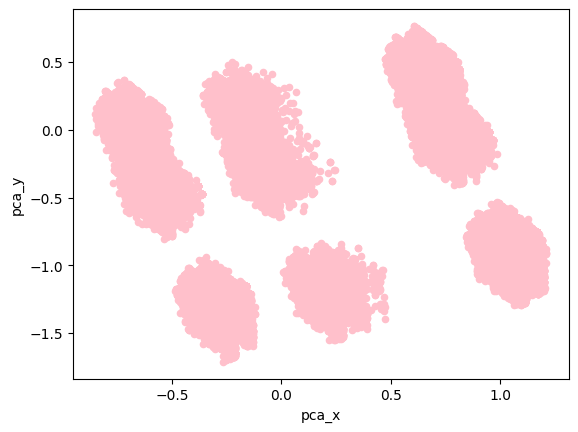

In [0]:
from pyspark.ml.feature import PCA
from pyspark.ml.functions import vector_to_array
import matplotlib.pyplot as plt

# Apply PCA with k=2 to reduce the feature vector to two dimensions
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(prepared_demo_df)
pca_demo_df = pca_model.transform(prepared_demo_df)

print(f"Displaying all the df")
display(pca_demo_df.limit(7))
print(f"Displaying relevant colums only")
display(pca_demo_df.select("household_id", "features", "pca_features").limit(7))

# Convert the PCA output vector to an array to easily extract each component
pca_array_df = pca_demo_df.withColumn("pca_array", vector_to_array("pca_features"))

# Create separate columns for the first and second principal components
pca_plot_df = pca_array_df \
    .withColumn("pca_x", col("pca_array")[0]) \
    .withColumn("pca_y", col("pca_array")[1])


# Convert to Pandas DataFrame and create a scatter plot with pink points
pca_plot_df.toPandas().plot.scatter(x='pca_x', y='pca_y', color='pink')


### Clustering

**K-means clustering and distance to centroid**

In this part, the `KMeans` algorithm is applied to the final `features` vector with `k = 3` clusters and a fixed random seed for reproducibility.  
Each row is assigned to a cluster, stored in the `cluster` column.

Then, the cluster centers are retrieved and a custom `UDF` computes the Euclidean distance from each point to its assigned cluster centroid.  
The distance is calculated by summing the squared differences for each dimension and taking the square root.

A new column `distance_to_centroid` is added to the DataFrame to store this value for each row.

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from pyspark.ml.linalg import Vectors
import builtins


# Apply K-means clustering with k = c = 6 
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=6, seed=3)

# Fit the K-means model on the prepared DataFrame
kmeans_model = kmeans.fit(prepared_demo_df)

# Transform to assign each row to a cluster
clustered_df = kmeans_model.transform(prepared_demo_df)

# Get cluster centers
centers = kmeans_model.clusterCenters()

# UDF to compute Euclidean distance to cluster center
def compute_distance(features, cluster_id):
    center = centers[cluster_id]
    diff = [(a - b) ** 2 for a, b in zip(features, center)]
    return float(builtins.sum(diff) ** 0.5)

distance_udf = udf(compute_distance, FloatType())

# Add a distance column
clustered_df = clustered_df.withColumn(
    "distance_to_centroid",
    distance_udf(col("features"), col("cluster"))
)


print(f"Displaying all the df")
display(clustered_df.limit(7))
print(f"Displaying relevant colums only")
display(clustered_df.select("household_id", "cluster", "distance_to_centroid").limit(7))

Displaying all the df


household_id,household_size,num_adults,num_generations,marital_status,race_code,dwelling_type,home_owner_status,length_residence,home_market_value,net_worth,gender_individual,education_highest,household_size_scaled,num_adults_scaled,num_generations_scaled,length_residence_scaled,home_market_value_scaled,net_worth_scaled,marital_status_index,race_code_index,dwelling_type_index,home_owner_status_index,gender_individual_index,education_highest_index,marital_status_ohe,race_code_ohe,dwelling_type_ohe,home_owner_status_ohe,gender_individual_ohe,education_highest_ohe,features,cluster,distance_to_centroid
85,2,1,2,B,W,S,O,15,0.125,0.05,F,1,0.125,0.0,0.5,1.0,0.12412412412412413,0.05,3.0,0.0,0.0,0.0,1.0,0.0,"Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List())","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(), values -> List())","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 18, indices -> List(0, 2, 3, 4, 5, 9, 12, 13, 15), values -> List(0.125, 0.5, 1.0, 0.12412412412412413, 0.05, 1.0, 1.0, 1.0, 1.0))",1,0.95686495
2073,1,1,2,M,H,S,O,15,0.15,0.1,F,1,0.0,0.0,0.5,1.0,0.14914914914914915,0.1,0.0,2.0,0.0,0.0,1.0,0.0,"Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(2), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(), values -> List())","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 18, indices -> List(2, 3, 4, 5, 6, 11, 12, 13, 15), values -> List(0.5, 1.0, 0.14914914914914915, 0.1, 1.0, 1.0, 1.0, 1.0, 1.0))",2,0.8481486
2523,7,6,3,M,W,S,O,15,0.1,0.1,M,2,0.75,1.0,1.0,1.0,0.0990990990990991,0.1,0.0,0.0,0.0,0.0,0.0,1.0,"Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))","Map(vectorType -> dense, length -> 18, values -> List(0.75, 1.0, 1.0, 1.0, 0.0990990990990991, 0.1, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0))",0,1.329641
2717,3,2,2,S,W,S,O,11,0.125,0.2,M,3,0.25,0.2,0.5,0.7333333333333333,0.12412412412412413,0.2,1.0,0.0,0.0,0.0,0.0,2.0,"Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(2), values -> List(1.0))","Map(vectorType -> dense, length -> 18, values -> List(0.25, 0.2, 0.5, 0.7333333333333333, 0.12412412412412413, 0.2, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0))",1,1.4315091
3364,2,2,2,M,W,S,O,15,0.1,0.1,M,1,0.125,0.2,0.5,1.0,0.0990990990990991,0.1,0.0,0.0,0.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length 

Displaying relevant colums only


household_id,cluster,distance_to_centroid
85,1,0.95686495
2073,2,0.8481486
2523,0,1.329641
2717,1,1.4315091
3364,5,0.5861586
4046,5,0.9358106
4303,1,0.9705721


### Dividing households into subsets

In this part, households are partitioned by their clusters, and then ordered by their distance to the centroid of each cluster. Each household is assigned a row number within the cluster, with the closest households to the centroid ranked first.

Next, the households are divided into 18 subsets:

**3rds subset** – Every 3rd household in the cluster.

**17ths subset** – Every 17th household in the cluster.

**Full subset** – This includes all households in the cluster.

These subsets will allow us to analyze how different groups of households behave with respect to their viewing habits, particularly in relation to their proximity to the cluster centroid.

In [0]:
from pyspark.sql.window import Window  

# Create a window specification to order households within each cluster by distance to centroid
window_spec = Window.partitionBy("cluster").orderBy("distance_to_centroid")  # Partition by cluster and order by distance to centroid

# Add a column for the row number within each cluster ordered by distance to centroid
df_with_order = clustered_df.withColumn("row_num", row_number().over(window_spec))  # Adding row number to the DataFrame

# Create the subsets: 3rds, 17ths, Full
df_3rds = df_with_order.filter((col("row_num") % 3) == 0)  # Every 3rd household (3rds subset)
df_17ths = df_with_order.filter((col("row_num") % 17) == 0)  # Every 17th household (17ths subset)
df_full = df_with_order  # Full subset includes all households

# Dictionaries to store the subsets permanently
full_subsets = {}
thirds_subsets = {}
seventeenths_subsets = {}

for k in range(6):
    # Filter each subset for the current cluster
    df_full_k = df_full.filter(col("cluster") == k)
    df_3rds_k = df_3rds.filter(col("cluster") == k)
    df_17ths_k = df_17ths.filter(col("cluster") == k)

    # Store the filtered DataFrames in dictionaries
    full_subsets[k] = df_full_k
    thirds_subsets[k] = df_3rds_k
    seventeenths_subsets[k] = df_17ths_k

    # Optional: display a sample for visual verification
    print(f"Full subset for cluster {k}")
    display(df_full_k.select("household_id", "cluster", "distance_to_centroid", "row_num").limit(5))


Full subset for cluster 0


household_id,cluster,distance_to_centroid,row_num
407843,0,0.70431626,1
3060593,0,0.70431626,2
3514686,0,0.70440924,3
2086992,0,0.70440924,4
4016114,0,0.70440924,5


Full subset for cluster 1


household_id,cluster,distance_to_centroid,row_num
2870796,1,0.80247897,1
3631022,1,0.80305946,2
3799062,1,0.80305946,3
2357515,1,0.80305946,4
107954,1,0.8031158,5


Full subset for cluster 2


household_id,cluster,distance_to_centroid,row_num
3217437,2,0.7250733,1
2190226,2,0.72576725,2
1319151,2,0.7274364,3
2951776,2,0.7274364,4
3173893,2,0.72756714,5


Full subset for cluster 3


household_id,cluster,distance_to_centroid,row_num
2424547,3,0.73912007,1
3216288,3,0.74081695,2
3462985,3,0.74170053,3
2127682,3,0.7427937,4
2310490,3,0.7433983,5


Full subset for cluster 4


household_id,cluster,distance_to_centroid,row_num
2346443,4,0.986769,1
104917,4,0.9897022,2
2041426,4,0.99178886,3
1482762,4,0.9930077,4
2077425,4,0.9930541,5


Full subset for cluster 5


household_id,cluster,distance_to_centroid,row_num
4023076,5,0.51603377,1
1996154,5,0.51603377,2
2076499,5,0.5163706,3
2197121,5,0.5163706,4
2828482,5,0.5163706,5


### Cluster’s Viewing Analysis

**Explanation**

In this cell, we perform the final step of our cluster viewing analysis.  
The goal is to compare how popular each TV station is inside each cluster **and** each subset (Full, 3rds, 17ths) relative to the general population.

Here’s what happens in this block:

1️⃣ **Calculate General Popularity:**  
   - We first compute the total number of viewings for each `station_num` in the entire dataset (`viewing_static_df`).
   - We divide each station’s total by the overall number of viewings to get the **general popularity percentage** (`popularity_general`).

2️⃣ **Loop Through Each Cluster:**  
   - For each cluster (0 to 5), we take the `Full`, `3rds`, and `17ths` subsets.
   - We join each subset with the viewing data to get only the relevant viewings for that cluster/subset.
   - We count how many viewing events each `station_num` has within the subset.

3️⃣ **Calculate Subset Popularity:**  
   - For each subset of the cluster, we compute the **subset popularity rating** by dividing the station’s count by the total viewings in that subset and multiplying by 100.

4️⃣ **Compute `diff_rank`:**  
   - For each station in each subset, we join the subset rating with the general rating.
   - We subtract the general popularity from the subset’s popularity:
     ```
     diff_rank = subset.pop_rating - popularity_general
     ```
   - This `diff_rank` shows whether the station is **more or less popular** in that cluster/subset compared to the average household.

5️⃣ **Return the Top 7:**  
   - We order the stations by `diff_rank` (highest first).
   - We display the **Top 7 stations** for each subset (Full, 3rds, 17ths).
   - The results are printed clearly for each cluster with clear headers.

In the end, this gives us a clear, side-by-side comparison of how each cluster’s subsets differ from the general population in their station preferences.


In [0]:

# Calculate the general popularity of each station in the entire dataset
df_station_count_general = viewing_static_df.groupBy("station_num").agg(count("*").alias("general_view_count"))
total_general_views = viewing_static_df.count() 
df_station_general_rating = df_station_count_general.withColumn("popularity_general", 
                                                                   (col("general_view_count") / total_general_views) * 100)


# Join the viewing data with the subsets 
for k in range(6):
  df_viewing_full_k = full_subsets[k].join(viewing_static_df, "household_id")
  df_viewing_3rds_k = thirds_subsets[k].join(viewing_static_df, "household_id")
  df_viewing_17ths_k = seventeenths_subsets[k].join(viewing_static_df, "household_id")

  # Aggregate the view counts per station for each subset
  df_station_count_full_k = df_viewing_full_k.groupBy("station_num").agg(count("*").alias("view_count_full_k"))
  df_station_count_3rds_k = df_viewing_3rds_k.groupBy("station_num").agg(count("*").alias("view_count_3rds_k"))
  df_station_count_17ths_k = df_viewing_17ths_k.groupBy("station_num").agg(count("*").alias("view_count_17ths_k"))

  # Calculate the total number of views for each subset
  total_views_full_k = df_viewing_full_k.count()
  total_views_3rds_k = df_viewing_3rds_k.count()
  total_views_17ths_k = df_viewing_17ths_k.count()

  df_rating_full_k = df_station_count_full_k.withColumn(
    "pop_rating",
    (col("view_count_full_k") / total_views_full_k) * 100)

  df_rating_3rds_k = df_station_count_3rds_k.withColumn(
    "pop_rating",
    (col("view_count_3rds_k") / total_views_3rds_k) * 100)

  df_rating_17ths_k = df_station_count_17ths_k.withColumn(
    "pop_rating",
    (col("view_count_17ths_k") / total_views_17ths_k) * 100)
  
 # Join subset-cluster with general rating and compute diff_rank
  df_diff_rank_full_k = df_rating_full_k.join(
        df_station_general_rating,
        on="station_num"
    ).withColumn(
        "diff_rank",
        col("pop_rating") - col("popularity_general"))

  df_diff_rank_3rds_k = df_rating_3rds_k.join(
        df_station_general_rating,
        on="station_num"
    ).withColumn(
        "diff_rank",
        col("pop_rating") - col("popularity_general"))

  df_diff_rank_17ths_k = df_rating_17ths_k.join(
        df_station_general_rating,
        on="station_num"
    ).withColumn(
        "diff_rank",
        col("pop_rating") - col("popularity_general"))

  print(f"++++++++++++++++++++++++++++++++++++++++++++++++++ Cluster {k} ++++++++++++++++++++++++++++++++++++++++++++++++++")

 # Top 7 for each subset per clusters
  print(f"===== Cluster {k} — Full Subset =====")
  display(df_diff_rank_full_k.select("station_num", "diff_rank").orderBy(col("diff_rank").desc()).limit(7))

  print(f"===== Cluster {k} — 3rds Subset =====")
  display(df_diff_rank_3rds_k.select("station_num", "diff_rank").orderBy(col("diff_rank").desc()).limit(7))

  print(f"===== Cluster {k} — 17ths Subset =====")
  display(df_diff_rank_17ths_k.select("station_num", "diff_rank").orderBy(col("diff_rank").desc()).limit(7))




++++++++++++++++++++++++++++++++++++++++++++++++++ Cluster 0 ++++++++++++++++++++++++++++++++++++++++++++++++++
===== Cluster 0 — Full Subset =====


station_num,diff_rank
60179,0.3920006870166719
16374,0.22730308873892513
49788,0.2045526380494167
32645,0.1001779326043215
10335,0.08745533979025041
50747,0.08060981371936737
61854,0.07566834124361119


===== Cluster 0 — 3rds Subset =====


station_num,diff_rank
60179,0.2783677460567828
32645,0.2474538973497753
16374,0.2133826552268936
45507,0.14576547171833648
49788,0.13701283399803454
33585,0.09696303474071603
34215,0.08941775695329998


===== Cluster 0 — 17ths Subset =====


station_num,diff_rank
16374,0.44015895633866586
49788,0.2507801649439476
11069,0.23357932061068398
59684,0.22398065113151377
61522,0.22156199871542392
35070,0.2151831454682132
30754,0.18897596913173967


++++++++++++++++++++++++++++++++++++++++++++++++++ Cluster 1 ++++++++++++++++++++++++++++++++++++++++++++++++++
===== Cluster 1 — Full Subset =====


station_num,diff_rank
74796,0.09908511426226463
16615,0.07821507285923013
58515,0.0729052049584783
15433,0.06216254750469358
11867,0.05490510429148865
10145,0.05024015654787872
18151,0.045981363105474835


===== Cluster 1 — 3rds Subset =====


station_num,diff_rank
74796,0.19205720104508817
58515,0.11870899430241932
35859,0.1028220230042531
10518,0.09814996204235371
16615,0.09292315667874906
11344,0.07944274723940087
10510,0.07909147573707428


===== Cluster 1 — 17ths Subset =====


station_num,diff_rank
11867,0.35290131793404533
14902,0.28453457433152196
21762,0.24147654427493798
11158,0.24030938571767846
16123,0.23721004363946765
10057,0.22036591342893036
16615,0.21562683667321847


++++++++++++++++++++++++++++++++++++++++++++++++++ Cluster 2 ++++++++++++++++++++++++++++++++++++++++++++++++++
===== Cluster 2 — Full Subset =====


station_num,diff_rank
12131,1.0873718024502066
11118,0.7932517659986893
10222,0.732710780236983
10171,0.6282651264421779
59684,0.49541771437156923
44714,0.3917355689600071
21883,0.3498073553587867


===== Cluster 2 — 3rds Subset =====


station_num,diff_rank
12131,1.6141901963714
10222,0.7665030496928619
11118,0.6734302045908704
10171,0.6665863724405245
21883,0.5241556772924398
10153,0.3739762196971319
10730,0.3468359802811165


===== Cluster 2 — 17ths Subset =====


station_num,diff_rank
12131,0.9006422304020296
59684,0.8354880290814857
10222,0.7901866538051914
10171,0.6656403381696374
17927,0.6042274561166381
11118,0.5680536534149202
10239,0.5520843265640794


++++++++++++++++++++++++++++++++++++++++++++++++++ Cluster 3 ++++++++++++++++++++++++++++++++++++++++++++++++++
===== Cluster 3 — Full Subset =====


station_num,diff_rank
35513,1.240484333024132
70387,0.9286958286186878
11706,0.8767181790254264
10918,0.8436296040147847
10179,0.7654444043606439
12131,0.7626475241621982
10171,0.7179734946114289


===== Cluster 3 — 3rds Subset =====


station_num,diff_rank
35513,1.3830534174449665
70387,0.9427997144607659
11706,0.8807201329673058
10918,0.853742954295177
10179,0.7744190720630169
11561,0.6002688034405138
16615,0.5939667949346893


===== Cluster 3 — 17ths Subset =====


station_num,diff_rank
10179,1.7264824283806728
10171,1.2597553104935018
35513,0.8782506722686201
11809,0.8369307604534963
11706,0.8294960688213109
12439,0.6815576694208372
10918,0.6420937790856437


++++++++++++++++++++++++++++++++++++++++++++++++++ Cluster 4 ++++++++++++++++++++++++++++++++++++++++++++++++++
===== Cluster 4 — Full Subset =====


station_num,diff_rank
12131,0.8096983046297903
10171,0.5274324745755883
70387,0.480288515812175
10918,0.44120210236460744
11706,0.3840230810500525
35513,0.38084678359058927
10642,0.36311743823346204


===== Cluster 4 — 3rds Subset =====


station_num,diff_rank
12131,0.8154696791559444
10642,0.6005462326083979
70387,0.535381041391476
10918,0.5155404035510739
10171,0.4871518413529654
11706,0.4131485654024128
11809,0.41206461073214845


===== Cluster 4 — 17ths Subset =====


station_num,diff_rank
10171,1.5215415231869125
12131,1.1390400244551009
35513,0.9044530093120269
12729,0.8751022222134557
70387,0.8616330975482037
10918,0.7096803814268268
14767,0.7025128641455802


++++++++++++++++++++++++++++++++++++++++++++++++++ Cluster 5 ++++++++++++++++++++++++++++++++++++++++++++++++++
===== Cluster 5 — Full Subset =====


station_num,diff_rank
60179,0.17028966469247164
16374,0.14632688402406413
19606,0.10247038444002322
11713,0.09290124219643248
14771,0.08079973308788535
11661,0.0792271519320012
57708,0.06647335945716687


===== Cluster 5 — 3rds Subset =====


station_num,diff_rank
60179,0.1437483458476545
19606,0.13593091470669733
57708,0.12315933196856826
11713,0.11394151835565286
14776,0.09620721339450289
56905,0.08256761081317332
15433,0.08220952117462982


===== Cluster 5 — 17ths Subset =====


station_num,diff_rank
16374,0.4398887132226128
64312,0.3910525452732496
60179,0.3252874063608482
31046,0.21792817196868502
49788,0.1656759308130189
46811,0.15237013149199632
18544,0.1351602258377362


## Dynamic Data Analysis - Streaming (35 points)

In [0]:

# SCHEMA = "device_id STRING, event_date INT, event_time INT, station_num STRING, prog_code STRING, household_id STRING"
# kafka_server = "kafka.eastus.cloudapp.azure.com:29092"
# topic = "view_data" 
# OFFSETS_PER_TRIGGER = 50000

# streaming_df = spark.readStream\
#                   .format("kafka")\
#                   .option("kafka.bootstrap.servers", kafka_server)\
#                   .option("subscribe", topic)\
#                   .option("startingOffsets", "earliest")\
#                   .option("failOnDataLoss",False)\
#                   .option("maxOffsetsPerTrigger", OFFSETS_PER_TRIGGER)\
#                   .load()\
#                   .select(from_csv(decode("value", "US-ASCII"), schema=SCHEMA).alias("value")).select("value.*")


# ########## QUERY EXAMPLE ##########

# station_counts = streaming_df.groupBy("station_num").count()

# count_viewings_per_station_query =station_counts.writeStream\
# .queryName('num_viewing')\
# .format("memory")\
# .outputMode("complete")\
# .start()

# time.sleep(10)

# for i in range(10):
#     print("Batch number: "+str(i))
#     print(count_viewings_per_station_query.status)
#     spark.sql('SELECT * FROM num_viewing ORDER BY count DESC LIMIT 10').show()
#     time.sleep(5)
    
# count_viewings_per_station_query.stop()


## Streaming Cluster Analysis (3rds Subset)

This code implements the final part of the project: streaming-based cluster analysis using PySpark Structured Streaming and Kafka.


### Approach

1. **Kafka Ingestion**: 
   A streaming DataFrame is created from a Kafka topic. Each batch processes up to 50,000 events using a predefined schema.

2. **Accumulator Logic**:  
   A global accumulator `accumulated_df` stores all past batch data. This allows computing cumulative popularity statistics over time, which is required to calculate global station popularity.

3. **Global Popularity**:  
   After each batch, the code computes the total station popularity across **all accumulated data**, representing the global viewing distribution.

4. **Cluster-wise Popularity and Diff Rank**:
   For each of the 6 clusters (`thirds_subsets[k]`), the code filters relevant views, calculates per-cluster station popularity, and compares it with the global popularity to compute the `diff_rank`.

5. **Top-7 Selection**:  
   The stations with the highest positive `diff_rank` in each cluster are selected and displayed.

6. **Streaming Control**:
   A batch counter ensures that **at least 3 micro-batches** are processed. Once 3 batches are received and handled, the streaming query stops.

### Key Design Choices

- The `diff_rank` is computed **only** using streaming data (no static data).
- An inner join is used when comparing cluster and global popularity to ensure consistency in station sets.
- Batch-wise accumulation guarantees a progressive and fair comparison between cluster-specific and global viewing behavior.




In [0]:
import time

SCHEMA = "device_id STRING, event_date INT, event_time INT, station_num STRING, prog_code STRING, household_id STRING"
kafka_server = "kafka.eastus.cloudapp.azure.com:29092"
topic = "view_data"
OFFSETS_PER_TRIGGER = 50000

streaming_df = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_server) \
    .option("subscribe", topic) \
    .option("startingOffsets", "earliest") \
    .option("failOnDataLoss", False) \
    .option("maxOffsetsPerTrigger", OFFSETS_PER_TRIGGER) \
    .load() \
    .select(from_csv(decode("value", "US-ASCII"), schema=SCHEMA).alias("value")) \
    .select("value.*")

# Accumulator to store past batch data
accumulated_df = None
batch_counter = {"count": 0}

def process_batch(batch_df, batch_id):
    global accumulated_df

    print(f"\n======================= BATCH {batch_counter['count'] + 1} =======================")

    # Accumulate batch data
    if accumulated_df is None:
        accumulated_df = batch_df
    else:
        accumulated_df = accumulated_df.union(batch_df)

    # 1. Compute GLOBAL popularity (all households across all clusters so far)
    df_station_count_global = accumulated_df.groupBy("station_num").agg(count("*").alias("view_count_global"))
    total_views_global = accumulated_df.count()

    if total_views_global == 0:
        print("No views yet in accumulated data.")
        return

    df_global_rating = df_station_count_global.withColumn(
        "popularity_general", (col("view_count_global") / total_views_global) * 100
    ).select("station_num", "popularity_general")

    # 2. Process each cluster separately
    for k in range(6):
        df_thirds_k = thirds_subsets[k]
        df_viewing_k = df_thirds_k.join(accumulated_df, on="household_id")

        total_views_cluster = df_viewing_k.count()

        if total_views_cluster == 0:
            print(f"Cluster {k}: no data yet.")
            continue

        # Popularity inside cluster
        df_station_count_k = df_viewing_k.groupBy("station_num").agg(count("*").alias("view_count_k"))

        df_rating_k = df_station_count_k.withColumn(
            "pop_rating", (col("view_count_k") / total_views_cluster) * 100
        )

        # Compute diff_rank: local vs global
        df_diff_rank = df_rating_k.join(
            df_global_rating,
            on="station_num",
        ).withColumn(
            "diff_rank", col("pop_rating") - col("popularity_general")
        )

        # Top 7 by diff_rank
        top_7 = df_diff_rank.orderBy(col("diff_rank").desc()).limit(7)

        print(f"---- Cluster {k} — Top 7 diff_rank Stations (Batch {batch_counter['count'] + 1}) ----")
        top_7.select("station_num", "diff_rank").show()

    # Update batch counter
    batch_counter["count"] += 1


# Start the query
query = streaming_df.writeStream \
    .foreachBatch(process_batch) \
    .outputMode("append") \
    .start()

# Wait until at least 3 batches are processed
while batch_counter["count"] < 3:
    time.sleep(5)

query.stop()



======================= BATCH 1 =======================
---- Cluster 0 — Top 7 diff_rank Stations (Batch 1) ----
+-----------+-------------------+
|station_num|          diff_rank|
+-----------+-------------------+
|      32645| 0.8878130104196003|
|      11150| 0.5635038017459868|
|      11158|0.34131568572233173|
|      11187|0.33263137144466337|
|      10142|0.31499352295128136|
|      11164|0.29547676710785686|
|      66268| 0.2771546043368065|
+-----------+-------------------+

---- Cluster 1 — Top 7 diff_rank Stations (Batch 1) ----
+-----------+-------------------+
|station_num|          diff_rank|
+-----------+-------------------+
|      12131| 0.4247884416924663|
|      15433|0.32959339525283793|
|      14771| 0.2767884416924664|
|      70522|  0.274796697626419|
|      16300| 0.2547946336429308|
|      18510|0.24879669762641896|
|      11713| 0.2403859649122806|
+-----------+-------------------+

---- Cluster 2 — Top 7 diff_rank Stations (Batch 1) ----
+-----------+---------